In [31]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation

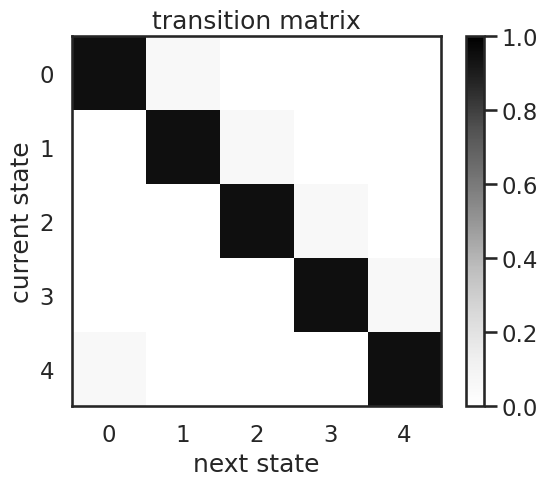

In [34]:
# Make a transition matrix
num_states = 5
transition_probs = (jnp.arange(num_states)**10).astype(float)
transition_probs /= transition_probs.sum()
transition_matrix = jnp.zeros((num_states, num_states))
for k, p in enumerate(transition_probs[::-1]):
    transition_matrix += jnp.roll(p * jnp.eye(num_states), k, axis=1)
    
plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
plt.xlabel("next state")
plt.ylabel("current state")
plt.title("transition matrix")
plt.colorbar()

In [39]:
# Make observation distributions
emission_dim = 2
num_lags = 1

keys = jr.split(jr.PRNGKey(0), num_states)
angles = jnp.linspace(0, 2 * jnp.pi, num_states, endpoint=False)
theta = jnp.pi / 25 # rotational frequency
weights = jnp.array([0.8 * random_rotation(key, emission_dim, theta=theta) for key in keys])
biases = jnp.column_stack([jnp.cos(angles), jnp.sin(angles), jnp.zeros((num_states, emission_dim - 2))])
covariances = jnp.tile(0.001 * jnp.eye(emission_dim), (num_states, 1, 1))

# Compute the stationary points
stationary_points = jnp.linalg.solve(jnp.eye(emission_dim) - weights, biases)

In [40]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

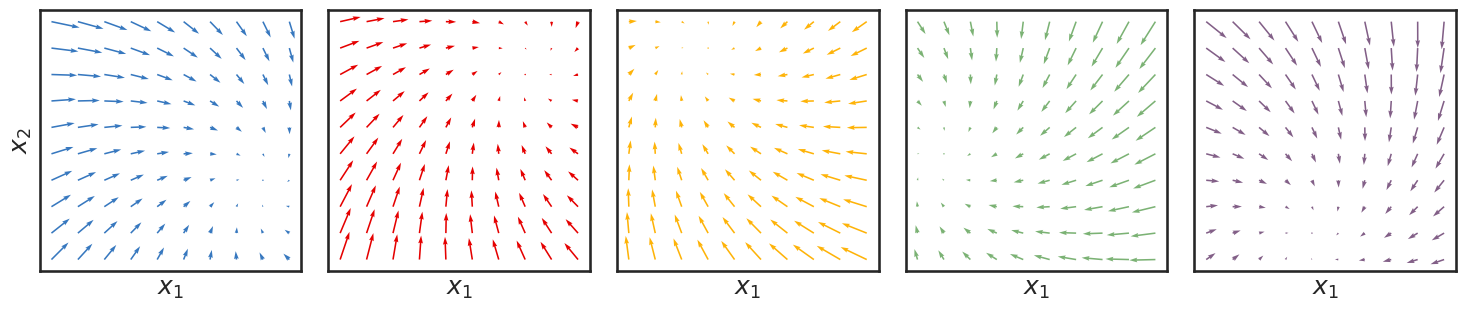

In [41]:
if emission_dim == 2:
    lim = 5
    x = jnp.linspace(-lim, lim, 10)
    y = jnp.linspace(-lim, lim, 10)
    X, Y = jnp.meshgrid(x, y)
    xy = jnp.column_stack((X.ravel(), Y.ravel()))

    fig, axs = plt.subplots(1, num_states, figsize=(3 * num_states, 6))
    for k in range(num_states):
        A, b = weights[k], biases[k]
        dxydt_m = xy.dot(A.T) + b - xy
        axs[k].quiver(xy[:, 0], xy[:, 1],
                    dxydt_m[:, 0], dxydt_m[:, 1],
                    color=colors[k % len(colors)])

        
        axs[k].set_xlabel('$x_1$')
        axs[k].set_xticks([])
        if k == 0:
            axs[k].set_ylabel("$x_2$")
        axs[k].set_yticks([])
        axs[k].set_aspect("equal")
                        

    plt.tight_layout()

In [42]:
# Make an Autoregressive (AR) HMM
true_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
true_params, _ = true_arhmm.initialize(initial_probs=jnp.ones(num_states) / num_states,
                                       transition_matrix=transition_matrix,
                                       emission_weights=weights,
                                       emission_biases=biases,
                                       emission_covariances=covariances)

time_bins = 10000
true_states, emissions = true_arhmm.sample(true_params, jr.PRNGKey(0), time_bins)

# Compute the lagged emissions (aka inputs)
inputs = true_arhmm.compute_inputs(emissions)

Text(0, 0.5, '$x_2$')

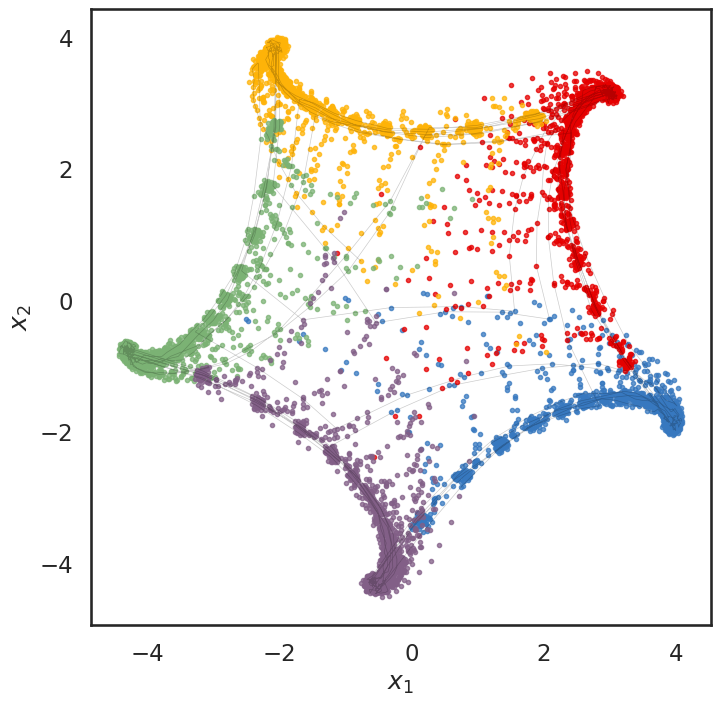

In [8]:
# Plot the sampled data
fig = plt.figure(figsize=(8, 8))
for k in range(num_states):
    plt.plot(*emissions[true_states==k].T, 'o', color=colors[k],
         alpha=0.75, markersize=3)
    
plt.plot(*emissions[:1000].T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

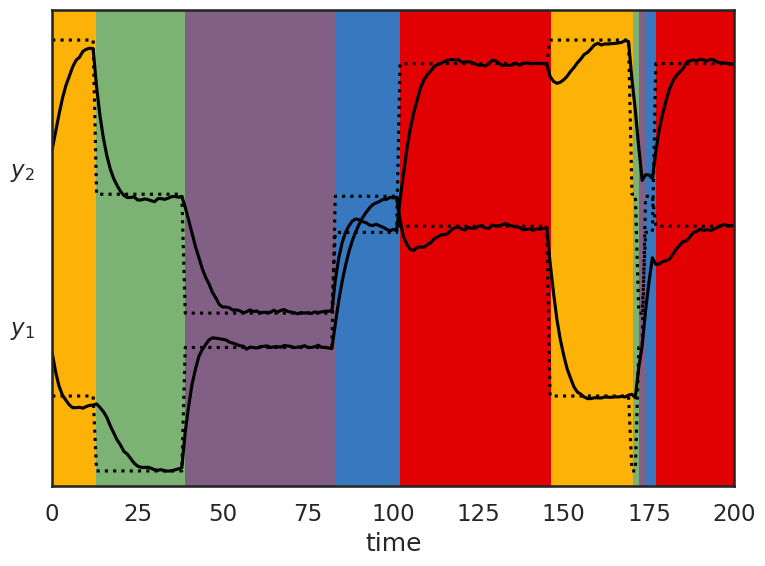

In [9]:


# Plot the emissions and the smoothed emissions
plot_slice = (0, 200)
lim = 1.05 * abs(emissions).max()
plt.figure(figsize=(8, 6))
plt.imshow(true_states[None, :],
           aspect="auto",
           cmap=cmap,
           vmin=0,
           vmax=len(colors)-1,
           extent=(0, time_bins, -lim, (emission_dim)*lim))


Ey = jnp.array(stationary_points)[true_states]
for d in range(emission_dim):
    plt.plot(emissions[:,d] + lim * d, '-k')
    plt.plot(Ey[:,d] + lim * d, ':k')

plt.xlim(plot_slice)
plt.xlabel("time")
plt.yticks(lim * jnp.arange(emission_dim), ["$y_{{{}}}$".format(d+1) for d in range(emission_dim)])

plt.tight_layout()



In [45]:
def compute_inputs(emissions, num_lags, emission_dim):
    """Helper function to compute the matrix of lagged emissions.

    Args:
        emissions: $(T \times N)$ array of emissions
        prev_emissions: $(L \times N)$ array of previous emissions. Defaults to zeros.

    Returns:
        $(T \times N \cdot L)$ array of lagged emissions. These are the inputs to the fitting functions.
    """
    prev_emissions = jnp.zeros((num_lags, emission_dim))

    padded_emissions = jnp.vstack((prev_emissions, emissions))
    num_timesteps = len(emissions)
    return jnp.column_stack([padded_emissions[lag:lag+num_timesteps]
                                for lag in reversed(range(num_lags))])
    

In [46]:
# Now fit an HMM to the emissions
key1, key2 = jr.split(jr.PRNGKey(0), 2)
test_num_states = num_states

num_lags = 2
# Initialize with K-Means
arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
params, props = arhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=emissions)

# Fit with EM
inpts = compute_inputs(emissions, num_lags, emission_dim)
fitted_params, lps = arhmm.fit_em(params, props, emissions, inputs=inpts)

In [48]:
np.shape(fitted_params[2].weights)

(5, 2, 4)

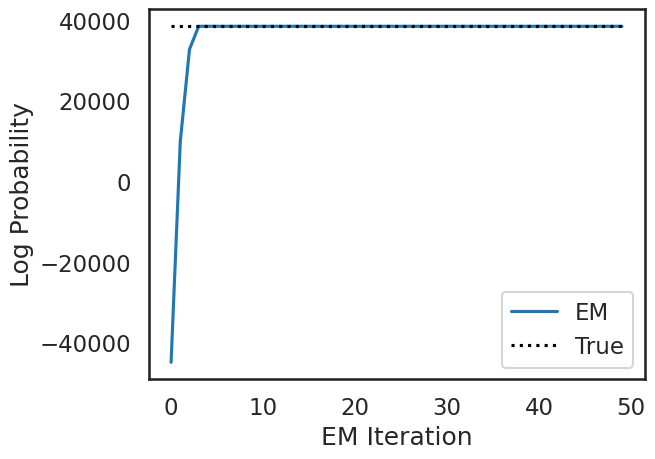

In [11]:
true_lp = true_arhmm.marginal_log_prob(true_params, emissions, inputs=inputs)
plt.plot(lps, label="EM")
plt.plot(true_lp * jnp.ones(len(lps)), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

In [12]:
posterior = arhmm.smoother(fitted_params, emissions, inputs=inputs)
most_likely_states = arhmm.most_likely_states(fitted_params, emissions, inputs=inputs)

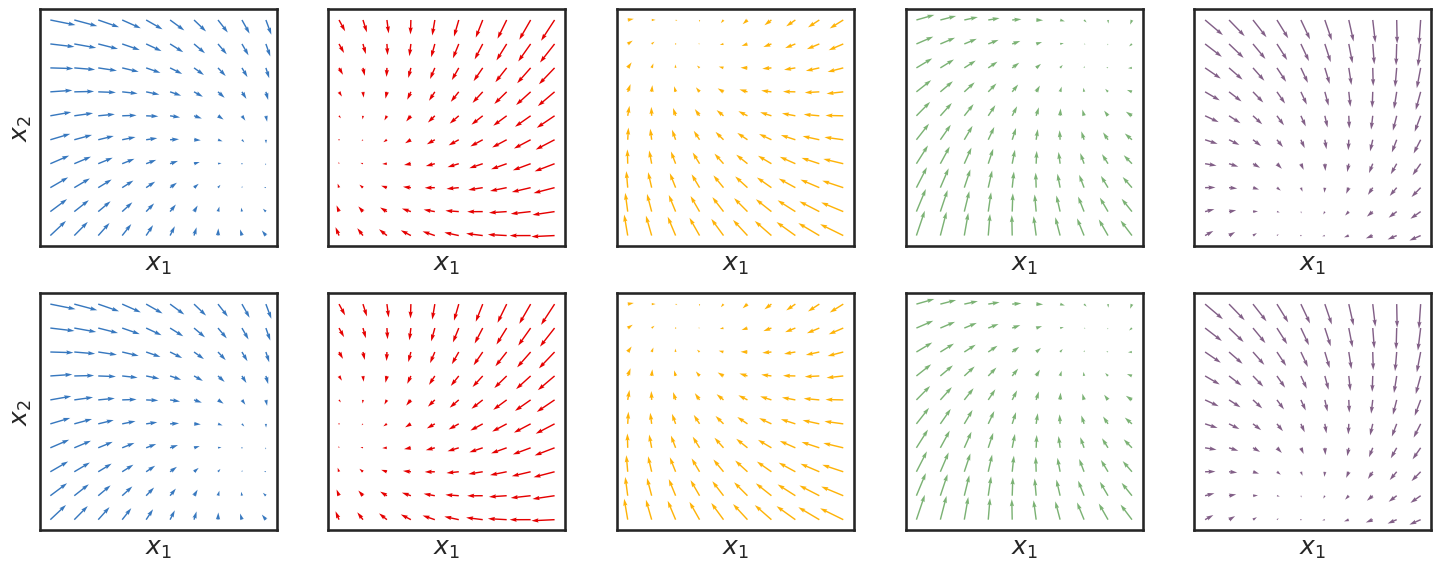

In [13]:
if emission_dim == 2:
    lim = abs(emissions).max()
    x = jnp.linspace(-lim, lim, 10)
    y = jnp.linspace(-lim, lim, 10)
    X, Y = jnp.meshgrid(x, y)
    xy = jnp.column_stack((X.ravel(), Y.ravel()))

    fig, axs = plt.subplots(2, max(num_states, test_num_states), figsize=(3 * num_states, 6))
    for i, model in enumerate([true_arhmm, arhmm]):
        for j in range(model.num_states):
            A = fitted_params.emissions.weights[j]
            b = fitted_params.emissions.biases[j]
            dxydt_m = xy.dot(A.T) + b - xy
            axs[i,j].quiver(xy[:, 0], xy[:, 1],
                        dxydt_m[:, 0], dxydt_m[:, 1],
                        color=colors[j % len(colors)])


            axs[i,j].set_xlabel('$x_1$')
            axs[i,j].set_xticks([])
            if j == 0:
                axs[i,j].set_ylabel("$x_2$")
            axs[i,j].set_yticks([])
            axs[i,j].set_aspect("equal")
                        

    plt.tight_layout()

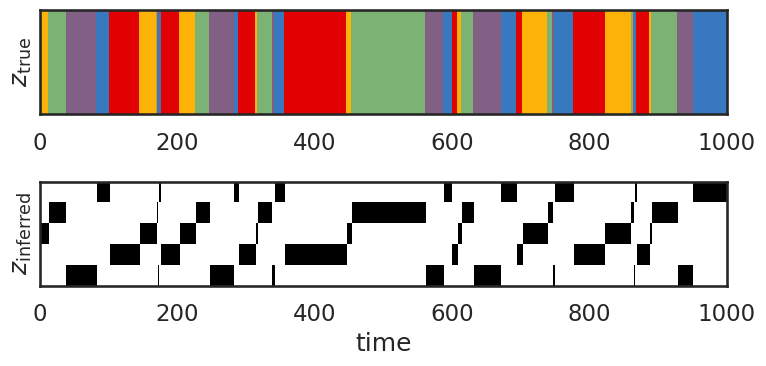

In [14]:
plot_slice = (0, 1000)
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(true_states[None,num_lags:], aspect="auto", interpolation="none", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(posterior.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

In [15]:
sampled_states, sampled_emissions = arhmm.sample(fitted_params, jr.PRNGKey(0), time_bins)

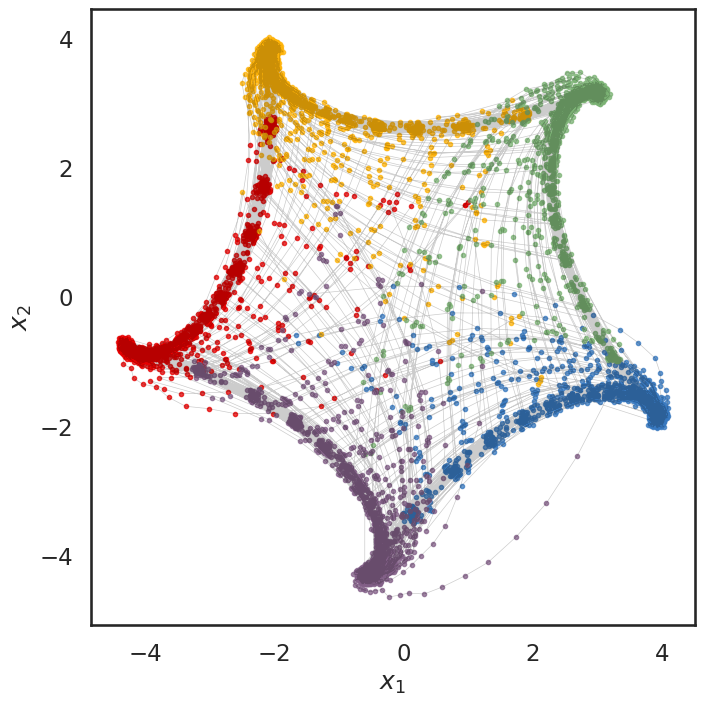

In [16]:


fig = plt.figure(figsize=(8, 8))
for k in range(test_num_states):
    plt.plot(*sampled_emissions[sampled_states==k].T, 'o', color=colors[k % len(colors)],
         alpha=0.75, markersize=3)
    
plt.plot(*sampled_emissions.T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.gca().set_aspect("equal")

